Project: Titan Lightcurve - Polarization-phase curve

Author: Alex Medina

Organization: University of Central Florida

In [2]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Most important import, in order to read and manipulate image in .IMG or VICAR format
#The python package is called "rms-vicar"
import vicar
#The second most important package to use is called "opencv"
#Used to manipulate general images
#Not used in the brightness phase curves but to keep it consistent with the polarization phase curves
import cv2

Polarized images are created using the make_polar_virtual_machine.sav IDLVM script; with polarization being calculated by taking ratios in the iamges using different polarizers. However, this process has no knowledge of which pixels are on Titan and which pixels are not, so the entire image has polarization values. The values away from Titan are a combination of light spread beyond the limb from the point spread function, and noise in the CCD and possibly also some stray light if the camera is pointing close to Saturn or the Sun. So, to interpret the polarization image I needed to restrict my analysis to the disk of Titan, including pixels beyond the terminator since Titan’s extended atmosphere is lit by the sun over a large region beyond the geometric terminator. For the same reason, values in the theta image(for angle of linear polarization) should be ignored if they are not on the target.

For the $\frac{I}{F}$ images this was not critical since the intensity drops to near zero sufficiently far from the target, and you want to include intensity beyond the limb. To only consider pixels within the disk of Titan in the image, I used the python package, opencv. First, I create a copy of the image, to not mess with original strucure of the .IMG of .VIC images, and detect the disk or circle of Titan; after it is detected, the output is a pair of coordinates for the center of the disk. To define an effective radius for the disk of Titan, I just plot the total brightness of a circle centered on Titan for incresing radius and plot it: when the plot begins to plateau, pixels beyond this plateau are no relevant.

In [3]:
def image_center(image):
    #Creating a copy of the image to avoid messing with the original

    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #Detect circle; I leave these parameters as is but they can be adjust to make circle detection more or less negative
    #I found that this is the best combination of parameters
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    #If a circle is detected this will draw a circle and return center coordinates (x, y) with a radius a
    #But the radius is too rough, we determine it more accurately later, and we actually dont need to draw the circle
    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            #Draw a cirlce of radius 1 around center to show center
            #cv2.circle(image_copy, (x, y), r, (0, 255, 0), 2)
            #Draw a circle of radius r around center to show radius
            #cv2.circle(image_copy, (x, y), 1, (0, 0, 255), 3)
            #Show the image
            #cv2.imshow(image_copy)
            #print({x}, {y})
            return (x, y)
    #Debug
    else:
        print("No circle found")
        return None

#To determine the effective radius, as mentioned, I plot the brightness against increasing radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    #Each image is mach 1024 pixels wide, so set the maximum to 1000 to be safe
    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

        #Applying mask to the image
        #Masking is one of the most important features that I take advantage of with opencv
        #This makes it so the circle of Titan is the ONLY part of the image that is showing and the rest is turned to either 0 or 1
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Manual inspection and testing
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs. Radius")
    plt.show()

#To determine the effective radius, I originally used a gradient
#When the slope approaches 0, then that is a good point
#It works because Titan is really close to the Earth and the images have a lot of pixels
#But, in general, we don't have the luxury of so many pixels so just getting in the practice that this plateau point is determined when the difference between the current and previous pixel is...
#...much much less than the previous pixel
def effective_radius(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    #If no plateau is detected can return last radius
    #return radii[-1]

    #Debugging
    print("No plateau found")
    return None

Unlike brightness images where pixel units are in $\frac{I}{F}$, degree of linear polarization is unitless. To go from the intensity, polarization, and theta images to disk-integrated Q/I or polarization, I do a proper sum which takes into account how much each pixel contributes to the total. To give a little bit of background and starting with small assumptions; using Stokes vector, we define the degree of linear polarization(no circular polarization) as:

\begin{equation}
P = \frac{\sqrt{Q^2 + U^2}}{I}.
\end{equation}

Since each pixel has a calculated version of P, Q, and U, a more accurate representation is per pixel:

\begin{equation}
P_i = \frac{\sqrt{(Q_i)^2 + (U_i)^2}}{I_i}.
\end{equation}

So we can find the total degree of linear polarization by summing all pixels on Titan. In a simplified case, let's assume that there is no U, and there is only a Q component, when we can say:

\begin{equation}
P_i = \frac{Q_i}{I_i}.
\end{equation}

Which can be reworked as a weighted sum for total linear polarization or $\frac{Q}{I}$ as:

\begin{equation}
\frac{Q}{I} = P = \frac{\sum_{j} \frac{I_j}{F} P_j}{\sum_{j }\frac{I_j}{F}}.
\end{equation}

One last thing to note is there there are two ways to go about this, doing just the disk of Titan or the whole image.

Since we are doing a weighted sum and pixels off of the disk of Titan in the IF image fall to zero, the poalrization values off of the disk Titan won't contribute much at all, so we can jsut sum over entire image - although I put it both ways to be safe and test, then do a relative error. Additionally, from the brightness phase curves we saw that doing a deconvolution also produces less than a few percent error, so it will only take up more time so I will not be doing it here.

In [4]:
def simple_dlop(pol_image, if_image, center, radius):
    #pol short for polarization images
    mask_pol = np.zeros_like(pol_image)
    #Fills the circle with 1s and the outside is 0
    #So that when we sum, we multiply the image by the mask, and the 0 multiplication gets rid of eveything outside of the disk
    #And everything inside the disk is summed but stays the same because multiplied by 1
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    #ins short for I/F images
    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    #for the masked image
    weighted_mask = np.sum(if_masked * pol_masked)
    total_if_mask = np.sum(if_masked)
    masked = weighted_mask / total_if_mask

    #for the whole image
    weighted_whole = np.sum(if_image * pol_image)
    total_if = np.sum(if_image)
    whole = weighted_whole / total_if

    return masked, whole

Here, we input the path where the calibrated AND poalrized images are located. Of course, this is unique to my setup and the data that I have.

In [5]:
pol_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\CB2_P\CB2_POL'

#Have the same path
if_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\CB2_P\CB2_POL'

pol_if_metadata = r'C:\Users\Alex\Desktop\Titan\Polarized Images\CB2_P\CB2_POL\pol_data_new.csv'
#Reading the csv file
parameters_df = pd.read_csv(pol_if_metadata)

Because we have to sort through different files in the same folder, it gets kinda messy, but here is a way to make it work: I can group the center and effectiv radius (x, y, r) and create a dictionary, in the folder there are three .VIC that correspond to the same image, hence they have the same beginning but different ending, i.e NXXXXXX_pol.vic and NXXXXXXX_I_over_F.vic, so we can match the corrdinates from the I_over_F coordinates to the _pol.vic images.

In [6]:
#Grouping the circle center and radius for our dictionary
def find_circle_params(image_path):
    vic = vicar.VicarImage(image_path, strict=False)
    image = vic.data_2d
    center = image_center(image)
    radii, fluxes = radii_fluxes_from_image(image, center)
    eff_radius = effective_radius(radii, fluxes)
    return center, eff_radius

#Creating a dictionary with the opus_id being used as the key since it matches the polarized images and IF images
#And the corresponding center coordinates and effective radius are stored as the value

circle_params = {}
for filename in os.listdir(if_images):
    if filename.endswith('_I_over_F.vic'):
        coordinate_image_path = os.path.join(if_images, filename)
        opus_id = filename.split('_')[0]
        try:
            center, eff_radius = find_circle_params(coordinate_image_path)
            circle_params[opus_id] = (center, eff_radius)
            print(f'{filename}: {center}, {eff_radius}')
        #Debug
        except Exception as e:
            print(f"{filename}: {e}")

N1617164_I_over_F.vic: (np.int64(249), np.int64(249)), 201
N1617165_I_over_F.vic: (np.int64(278), np.int64(244)), 201
N1674325_I_over_F.vic: (np.int64(499), np.int64(511)), 546
N1675503_I_over_F.vic: (np.int64(485), np.int64(509)), 541
N1677312_I_over_F.vic: (np.int64(520), np.int64(513)), 546
N1677484_I_over_F.vic: (np.int64(541), np.int64(511)), 551
N1677856_I_over_F.vic: (np.int64(499), np.int64(517)), 536
N1678029_I_over_F.vic: (np.int64(535), np.int64(515)), 546
N1678201_I_over_F.vic: (np.int64(490), np.int64(511)), 546
N1678374_I_over_F.vic: (np.int64(542), np.int64(506)), 551
N1678546_I_over_F.vic: (np.int64(505), np.int64(512)), 551
N1680116_I_over_F.vic: (np.int64(509), np.int64(517)), 551
N1680806_I_over_F.vic: (np.int64(499), np.int64(527)), 536
N1682446_I_over_F.vic: (np.int64(482), np.int64(512)), 551
N1684255_I_over_F.vic: (np.int64(508), np.int64(513)), 546
N1684428_I_over_F.vic: (np.int64(524), np.int64(518)), 546
N1686496_I_over_F.vic: (np.int64(502), np.int64(508)), 5

Finally, we have a center and effective radius in order to mask the polarized image and calculate the total degree of linear polarization, or a simplified case of $\frac{Q}{I}$, and we already know the phase angle from the metadata. So this follows the exact same process as that of the brightness-phase curves, jsut with different naming conventions and a center and effective radius line.

In [7]:
#Lists for results, one for the masked version and one for the whole image
simple_dlops_m = []
simple_dlops_w = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
#Same loop as before but additional if for center coords and radius
for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
    #if filename.endswith('_Theta.vic'):
    #if filename.endswith('_Q.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        #Since these images are in .IMG(or .VIC) format, simple line to read image from rms-vicar package
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        #The coordinate images are also the _I_over_F.vic images just with that different ending
        #Removing that ending they have the exact same naming structure
        #Trying a replace, this works because _Pol.vic and _I_over_F.vic are both in the "polarized images" folder
        #I just named them differently for convenience
        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d


        opus_id = filename.split('_')[0]
        #Comparatively, in the brightness-phase curve we used metadata file from OPUS, but here i created my own
        #So no need to add the prefix 'co-iss-' or change from upper to lowercase
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        #opus_id in circle_params becasue both I_over_F and pol images have same naming convention before the understore defined in circle params
        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Assocating the meta data with the image, pixel_scale and phase_angle
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]

                s_dlop_m, s_dlop_w = simple_dlop(read_pol_image, read_if_image, center, eff_radius)

                #Creating array to plot
                phase_angles.append(phase_angle)
                simple_dlops_m.append(s_dlop_m)
                simple_dlops_w.append(s_dlop_w)

                #For manual inspection
                print(f'{filename}: {s_dlop_m}, {s_dlop_w}')

N1617164_Pol.vic: 0.34301552176475525, 0.34247085452079773
N1617165_Pol.vic: 0.34322258830070496, 0.34350401163101196
N1674325_Pol.vic: 0.34958699345588684, 0.35088515281677246
N1675503_Pol.vic: 0.15242160856723785, 0.15295571088790894
N1677312_Pol.vic: 0.3207065463066101, 0.3218895494937897
N1677484_Pol.vic: 0.40372273325920105, 0.4047674238681793
N1677856_Pol.vic: 0.38711875677108765, 0.38753601908683777
N1678029_Pol.vic: 0.2910366356372833, 0.29161569476127625
N1678201_Pol.vic: 0.261557012796402, 0.262387752532959
N1678374_Pol.vic: 0.30624863505363464, 0.3075850009918213
N1678546_Pol.vic: 0.38559824228286743, 0.387154221534729
N1680116_Pol.vic: 0.3596060574054718, 0.360847532749176
N1680806_Pol.vic: 0.3358915150165558, 0.3361669182777405
N1682446_Pol.vic: 0.1701265126466751, 0.17128542065620422
N1684255_Pol.vic: 0.22617049515247345, 0.2271500825881958
N1684428_Pol.vic: 0.26760756969451904, 0.26845747232437134
N1686496_Pol.vic: 0.23723237216472626, 0.23807986080646515
N1687565_Pol.vi

To see the relative error between using the whole image versus the masked image

In [8]:
def difference_q(q_m, q_w):
        #Since dealing witha arrays
        q_m = np.asarray(q_m)
        q_w = np.asarray(q_w)

        #Calculating the difference in the Q and U value between the whole image and the masked image
        diff_q = np.abs(q_m - q_w)

        #So the relative difference
        rel_diff_q = diff_q / np.abs(q_m)

        return rel_diff_q

simple_dlops_errors = difference_q(simple_dlops_m, simple_dlops_w)

print(f"Mean Q/I relative error: {np.mean(simple_dlops_errors)}")

Mean Q/I relative error: 0.006518408190459013


As the error is much much less than 1%, I just choose to plot the masked image for now. Now, we have all the important information, an image (or data point) with a degree of a simplified $\frac{Q}{I}$ (y) and a phase angle(x).

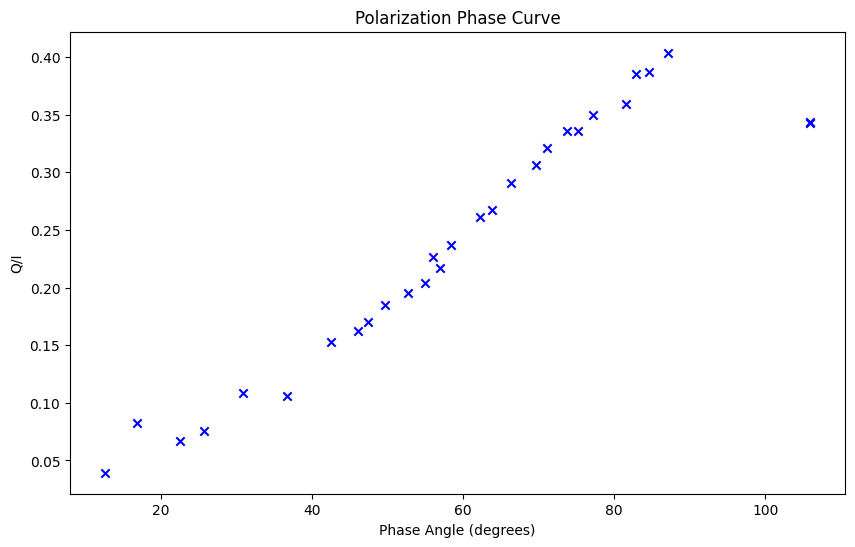

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops_m, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')
plt.show()

Having examined outliers(explained in procedure), as a final step for consistency, I use the preliminary plot to gauge an idea for the maximum value. Hence, with this last section, I manually adjust the y axis height and tick number(at least divisible by 5). X-axis remains consistant across all filters.

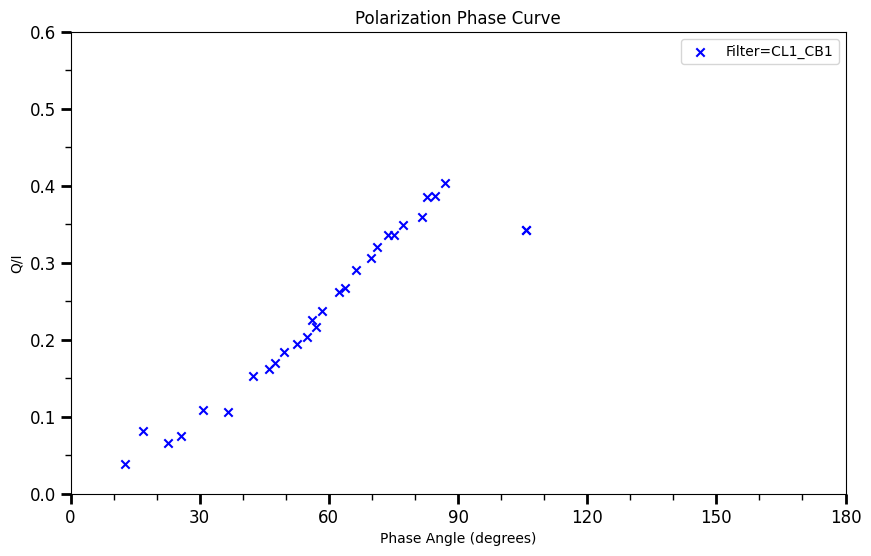

In [10]:
#Fancy plot for consistency across all plots but also visually will look better
filtername = 'CL1_CB1'

#Same as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops_m, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.1 for i in range(7)], minor=False)
ay.set_yticks([i * 0.05 for i in range(60)], minor=True) 
plt.ylim(0, 0.60)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()

Continuing with the assumption that U = 0, recall that we originally had the following equation:

\begin{equation}
\frac{Q}{I} = P = \frac{\sum_{j} \frac{I_j}{F} P_j}{\sum_{j }\frac{I_j}{F}}.
\end{equation}

Although I skipped pass this step, both the top and bottom have a factor that cancels out that looks like,

\begin{equation}
\frac {\mathcal{S^2}_{\text{pixel}}} {\pi R_{\text{target}}}.
\end{equation}

Hence, to determine the Stokes component Q by itself, we normalize in the same way as we normalize reflectivity,

\begin{equation}
Q = \frac{ \sum_{j} \frac{I_j P_j}{F} \mathcal{S^2}_{\text{pixel}}} {\pi {R^2}_{\text{target}}}.
\end{equation}

In [11]:
def simple_stokes_q(pol_image, if_image, center, radius, pixel_scale):

    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    R = 2575 #km

    weighted_mask = np.sum(if_masked * pol_masked)
    masked = (weighted_mask * pixel_scale**2) / (np.pi * R**2)

    weighted_whole = np.sum(if_image * pol_image)
    whole = (weighted_whole * pixel_scale**2) / (np.pi * R**2)

    return masked, whole

In [12]:
#We use the exact same files and images so nothing from the loop has to change other than the y variable which wil just calculate Q this time

simple_qs_m = []
simple_qs_w = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                sq_m, sq_w = simple_stokes_q(read_pol_image, read_if_image, center, eff_radius, pixel_scale)

                #Creating array to plot
                simple_qs_m.append(sq_m)
                simple_qs_w.append(sq_w)

                #For manual inspection
                print(f'{filename}: {sq_m}, {sq_w}')

N1617164_Pol.vic: 0.03460253790940322, 0.035199193305113535
N1617165_Pol.vic: 0.03440647835542218, 0.035028904152686294
N1674325_Pol.vic: 0.04755057341238128, 0.04783953465710615
N1675503_Pol.vic: 0.03343774477627886, 0.03365209383938289
N1677312_Pol.vic: 0.04797992612661323, 0.048275259584083366
N1677484_Pol.vic: 0.04878185500741839, 0.04902035548999304
N1677856_Pol.vic: 0.047219461057082315, 0.04741267277086025
N1678029_Pol.vic: 0.04557982080435185, 0.04580102149926767
N1678201_Pol.vic: 0.04356543654761159, 0.04380846820331488
N1678374_Pol.vic: 0.04632373832308342, 0.04662143604251109
N1678546_Pol.vic: 0.04865731797660058, 0.04895432860696211
N1680116_Pol.vic: 0.04763994836615141, 0.04790456260993638
N1680806_Pol.vic: 0.04731509712683579, 0.047497916697654206
N1682446_Pol.vic: 0.03508565418222518, 0.035402831413980755
N1684255_Pol.vic: 0.04232363793250419, 0.042612642385432005
N1684428_Pol.vic: 0.04491160228670194, 0.045172322850887146
N1686496_Pol.vic: 0.04204346667934522, 0.0423047

And again, to determine the relative error;

In [13]:
simple_qs_errors = difference_q(simple_qs_m, simple_qs_w)

print(f"Mean Q relative error: {np.mean(simple_qs_errors)}")

Mean Q relative error: 0.011215521558248558


Again, this error is around 1%, so for consistency, I'll just stick with using the masked image.

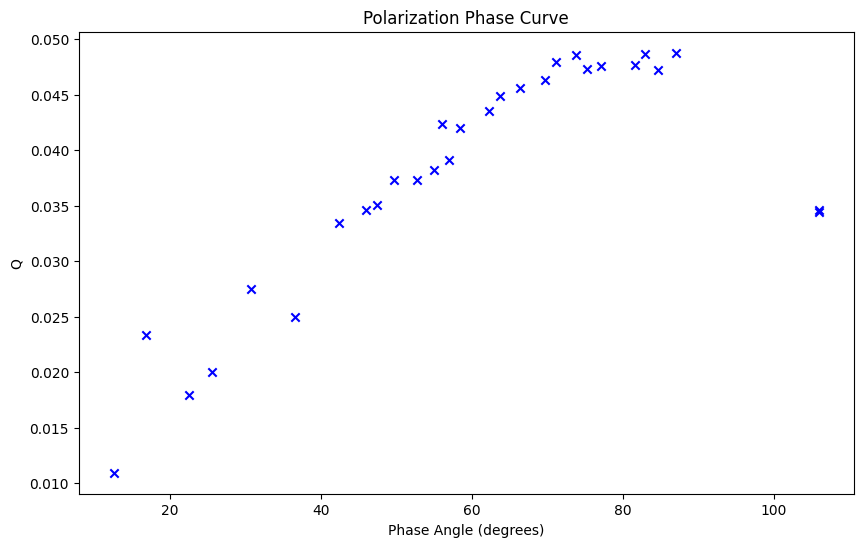

In [14]:
#And we plot again

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_qs_m, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

As a next step: ABOVE, we considered the case where U = 0, such that P = Q/I, but if there is both Q and U, we can determine and plot the Stokes parameters individually. So lets take it such that U is not 0, and what we would do in that case. By definition, the degree of linear poalrization is:

\begin{equation}
P = \frac{\sqrt{Q^2 + U^2}}{I}.
\end{equation}

The stokes parameters have the form:

\begin{equation}
Q = IPcos(2\theta)
\end{equation}

\begin{equation}
U = IPsin(2\theta)
\end{equation}

Where, we calcualte Q and U per pixel and add up each pixel to get a value for the disk, and can be normalized in the same way as the previous Q and reflectivity equations

\begin{equation}
Q = \frac{ \sum_{i} \frac{I_i}{F} P_i cos(2\theta_{i}) S_{pixel}^2 } {\pi R_{Titan}^2}.
\end{equation}

This defines Q and U before rotation, as is, with the camera Y axis as the axis with which the angle of polarization is determined by.

In [15]:
def pre_rot_q(pol_image, if_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    R = 2575 #km

    thet_rad_whole = np.deg2rad(thet_image)
    weighted_whole = np.sum(if_image * pol_image * np.cos(2*thet_rad_whole))
    whole = (weighted_whole * pixel_scale**2) / (np.pi * R**2)

    thet_rad_mask = np.deg2rad(thet_masked)
    weighted_mask = np.sum(if_masked * pol_masked * np.cos(2*thet_rad_mask))
    masked = (weighted_mask * pixel_scale**2) / (np.pi * R**2)

    return masked, whole


def pre_rot_u(pol_image, if_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    R = 2575 #km

    thet_rad_whole = np.deg2rad(thet_image)
    weighted_whole = np.sum(if_image * pol_image * np.sin(2*thet_rad_whole))
    whole = (weighted_whole * pixel_scale**2) / (np.pi * R**2)

    thet_rad_mask = np.deg2rad(thet_masked)
    weighted_mask = np.sum(if_masked * pol_masked * np.sin(2*thet_rad_mask))
    masked = (weighted_mask * pixel_scale**2) / (np.pi * R**2)

    return masked, whole

And we run the same look as a visual test because again, we use the same images, just changing the y axis and adding a theta section.

In [16]:
#We use the exact same files and images so nothing from the loop has to change other than the y variable which wil just calculate Q this time

pre_rot_qs_w = []
pre_rot_us_w = []
pre_rot_qs_m = []
pre_rot_us_m = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                prq_m, prq_w = pre_rot_q(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)
                pru_m, pru_w = pre_rot_u(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)

                #Creating array to plot
                pre_rot_qs_m.append(prq_m)
                pre_rot_qs_w.append(prq_w)
                pre_rot_us_m.append(pru_m)
                pre_rot_us_w.append(pru_w)

                #For manual inspection
                print(f'{filename}: {prq_m}, {prq_w}, {pru_m},{pru_w}')

N1617164_Pol.vic: 0.034451956202176406, 0.03498042550331456, 0.00027758134951239613,0.0002737017750211875
N1617165_Pol.vic: 0.016985249225767343, 0.017176163689021834, 0.029584186842689566,0.03010660375319139
N1674325_Pol.vic: -0.011801337112602053, -0.011869574245105425, -0.044458201335198115,-0.04456316084385549
N1675503_Pol.vic: -0.009242265116615843, -0.009314868350583124, 0.0269507749297498,0.027024341334515353
N1677312_Pol.vic: -0.04328836139299721, -0.043455575881444976, -0.014197499367065037,-0.014237150309112956
N1677484_Pol.vic: -0.04428195733431228, -0.04442421321286948, 0.0156384479424003,0.015687494078139307
N1677856_Pol.vic: -0.04496004062361729, -0.045114817351020846, -0.012349106758360245,-0.012393456955787904
N1678029_Pol.vic: -0.0422789102953972, -0.04244293097332824, -0.013118643411960833,-0.013155869430614855
N1678201_Pol.vic: -0.03129729049423107, -0.03141097101102456, 0.029126456275130067,0.029204608433457912
N1678374_Pol.vic: -0.02148092802246082, -0.021570214564

For a quick error analysis between using the whole image versus using the disk of Titan; The relative difference, while written for Q, can be applied to U the same.

In [17]:
prq_errors = difference_q(pre_rot_qs_m, pre_rot_qs_w)
pru_errors = difference_q(pre_rot_us_m, pre_rot_us_w)

print(f"Mean Q relative error: {np.mean(prq_errors)}")
print(f"Mean U relative error: {np.mean(pru_errors)}")

Mean Q relative error: 0.043991205965574626
Mean U relative error: 0.010242610724189983


Less than 5% across both Q and U components of the Stokes vectora means that using either the whole image or the masked image is negligible, buyt for consistency, I plot the masked version.

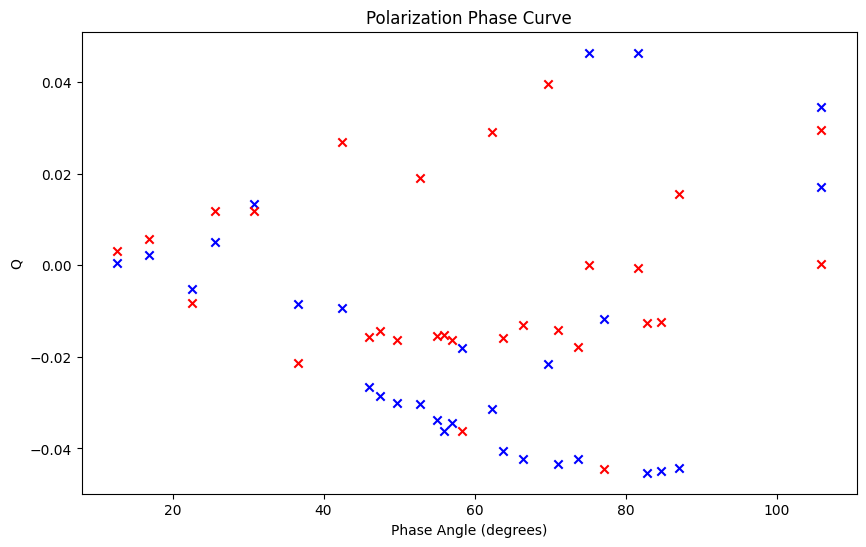

In [18]:
#For sanity we plot; looks pretty much exaclty the same whether or not we do the whole image os masked image

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, pre_rot_qs_m, color='b', marker='x')
plt.scatter(phase_angles, pre_rot_us_m, color='r', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

With the specific values of Q and U depending on the choice of the reference system. We introduce a new reference frame where Q_cam and U_cam are the stokes parameters before projection, such that we can find the new components after rotation as:

\begin{equation}

\begin{bmatrix} 
I \\ Q \\ U 
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(2\theta') & \sin(2\theta') \\
0 & -\sin(2\theta') & \cos(2\theta')
\end{bmatrix}

\begin{bmatrix} 
I_{\text{0}} \\ Q_{\text{0}} \\ U_{\text{0}} 
\end{bmatrix}
\end{equation}

Which gives us the following equations, where theta is the polarization(or projection) angle:

\begin{equation}
Q = Q_{0}cos(2\theta') + U_{0}sin(2\theta')
\end{equation}

\begin{equation}
U = -Q_{0}sin(2\theta') + U_{0}cos(2\theta')
\end{equation}

Here, Q_0 and U_0 are just the Stokes parameters given before rotation - hence the pre roated Q and U in the section above.


The Q/I that is gotten is, again, with respect to the camera axes, but we want thre Q/I with respect to the sun direction. To do that rotation, we need to know the angle that the camera Y axis makes with the direction to the sun as projected onto the image plane, and we can do that once we have the SUN_IMAGE_AZIMUTH from the imaging PDS node; I create a specific folder with that although on query it tends to be the same angle across filters.

A special case to ensure this works is a case where we consider U = 0, like above. This would mean that the electric field vector of polarized lights coming from Titan hs to be either parallel or perpendicular to the camera's Y-axis; this is done by setting the scattering plane to be perpendicular to the camera y-axis. If U = 0, then we can calculate the projection angle,

\begin{equation}
0 = -Q_{0}sin(2\theta') + U_{0}cos(2\theta')
\end{equation}

\begin{equation}
tan(2\theta') = \frac{U_{0}}{Q_{0}}
\end{equation}

\begin{equation}
\theta' = \frac{1}{2} arctan\frac{U_{0}}{Q_{0}}
\end{equation}

We've already built the functions to calculate Q_0 and U_0 in the original reference frame above, so now we just need to setup calculation for Q and $\theta$'.

So now we have Q and U in the sun frame, which is what we want, and then Q/I and U/I.

In [60]:
def rotate_scat_plane(q_o, u_o, rot_angle):
    #this will be the sun_image_azimuth
    #thet_prime = np.deg2rad(rot_angle)

    #testing roations by +- 90 and negative; rotations by 180 is exaclty the same by 2theta
    #thet_prime = np.deg2rad(rot_angle + 90) 
    #thet_prime = np.deg2rad(rot_angle - 90)
    thet_prime = np.deg2rad(-rot_angle)

    q_scat = q_o * np.cos(2 * thet_prime) + u_o * np.sin(2 * thet_prime)
    u_scat = -q_o * np.sin(2 * thet_prime) + u_o * np.cos(2 * thet_prime)

    #Special case where we rotate to U = 0
    thet_special = 0.5 * np.arctan2(u_o, q_o)
    q_spec = q_o * np.cos(2 * thet_special) + u_o * np.sin(2 * thet_special)
    
    return q_scat, u_scat, q_spec

#From the brightness phase curves, for total intensity; but since we are only doing the mask

def reflectivity(if_image, center, radius, pixel_scale):
    R = 2575 #km
    #Total number of pixels
    #n_pixel = np.pi * R**2 / pixel_scale**2

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if
    
    total_if = np.sum(if_masked)

    return (total_if * pixel_scale**2) / (np.pi * R**2)

def rotate_scat_over_i(q_scat, u_scat, q_spec, total_i):
    #q and u scat will be calculated with rotate scatter plane function
    #total i will be calculated with reflectivity
    #notable the normalization factors cancel out but don't want to rewrite everything

    q_over_i = q_scat / total_i
    u_over_i = u_scat / total_i
    q_over_i_spec = q_spec / total_i

    return q_over_i, u_over_i, q_over_i_spec

AND since we saw that the error between the whole and the masked images was les then 5% I am going to use just the masked version.

A few notes: In theory, the sun_image_azimuth should be equal to theta prime, theta_prime is the angle between the camera Y-axis and the projected direction to the sun on the image plane. This is exactly what SUN_IMAGE_AZIMUTH is intended to provide, but according to Bob West:
- The azimuth might be measured clockwise or counterclockwise

After some testing, taking the sun_image_azimuth as is does not produce and expected result; taking the negative of the sun_image_azimuth gives a pretty decent result - mirrors the U=0 result which cannot be a coincidence, so this measn we measure the angle CLOCKWISE; but it is also all negative Q values.

For now, I assume that clockwise is the correct orientation(will confirm). Upon reading some of the literature, if Q > 0, then polarization is parallel to the reference axis, and Q < 0 means it's perpendicular. But the direction of the reference axis is defined by the rotation angle, so if I'm off by 180 degrees, the physics is identical, it jsut flips the sign.

If you're off by 180°, the physics is identical, but Q flips sign. To handle this, I will flip the orientation, because I don't expect it to change the physics, we jst have to redefine what direction we will call positive Q.

In [64]:
scat_qs = []
scat_us = []
spec_qs = []

scat_qis = []
scat_uis = []
spec_qis = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]
                sun_image_azimuth = parameter_row['SUN_IMAGE_AZIMUTH'].values[0]
                
                prq_m, prq_w = pre_rot_q(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)
                pru_m, pru_w = pre_rot_u(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)

                #sun_image_azimuth as the rotation angle, and converted to radians within the function

                scat_q, scat_u, spec_q = rotate_scat_plane(prq_m, pru_m, sun_image_azimuth)
                calc_refl = reflectivity(read_if_image, center, eff_radius, pixel_scale)
                scat_qi, scat_ui, spec_qi = rotate_scat_over_i(scat_q, scat_u, spec_q, calc_refl)

                #Creating array to plot
                scat_qs.append(-scat_q)
                scat_us.append(scat_u)
                spec_qs.append(spec_q)

                scat_qis.append(-scat_qi)
                scat_uis.append(scat_ui)
                spec_qis.append(spec_qi)

                #For manual inspection
                print(f'{filename}: {scat_q}, {scat_u}, {spec_q}, {scat_qi}, {scat_ui}, {spec_qi}')

N1617164_Pol.vic: -0.03445096235341314, -0.00038148458158722854, 0.03445307442830434, -0.3415129399579207, -0.0037816627492138644, 0.34153387699004495
N1617165_Pol.vic: -0.03411285464657059, -0.00018960555515073856, 0.0341133815738721, -0.34029353552292596, -0.0018914144062557483, 0.3402987918978689
N1674325_Pol.vic: -0.04593413992535192, 0.002420333225917516, 0.04599786107642712, -0.3377031477702921, 0.017794044916780022, 0.3381716192238256
N1675503_Pol.vic: -0.028488742689471498, -0.00039404793227299124, 0.02849146773684789, -0.12986223200242342, -0.001796216300546738, 0.1298746537768228
N1677312_Pol.vic: -0.045554570630865765, -0.00048199067004037026, 0.04555712041348249, -0.3044950246647798, -0.0032217131877145962, 0.3045120678749345
N1677484_Pol.vic: -0.046937050540675214, -0.0015382086812648337, 0.0469622486621437, -0.3884549686241353, -0.012730344112702482, 0.3886635103917086
N1677856_Pol.vic: -0.04660957786000239, 0.001205380570222802, 0.04662516156118599, -0.38211876868774525,

Final plotting

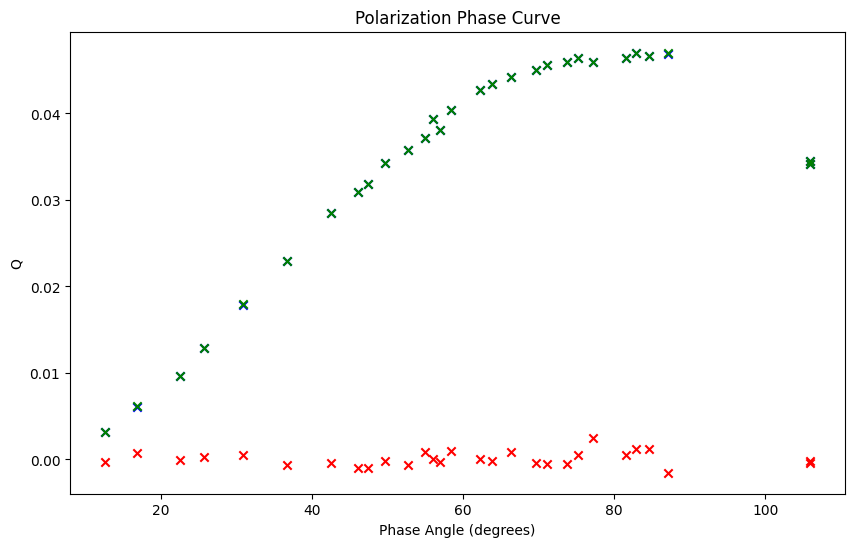

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, scat_qs, color='b', marker='x')
plt.scatter(phase_angles, scat_us, color='r', marker='x')
plt.scatter(phase_angles, spec_qs, color='g', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')
plt.show()

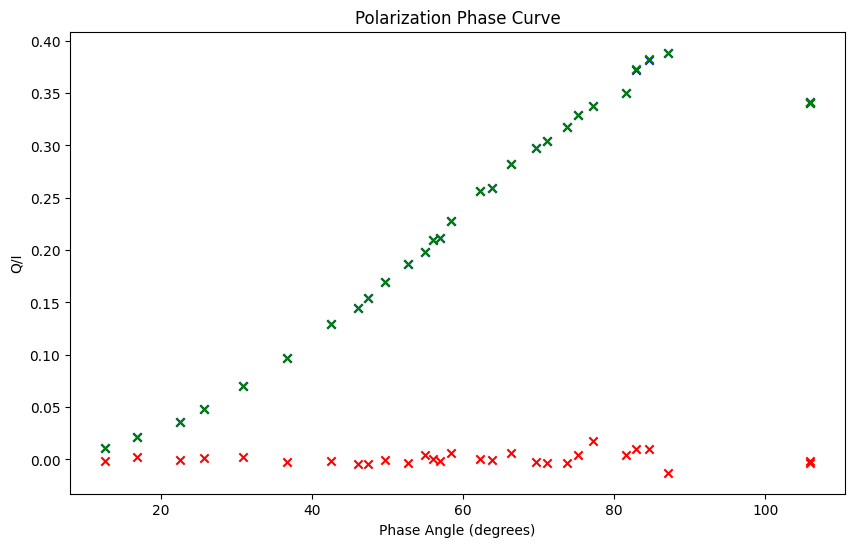

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, scat_qis, color='b', marker='x')
plt.scatter(phase_angles, scat_uis, color='r', marker='x')
plt.scatter(phase_angles, spec_qis, color='g', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')
plt.show()